In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import torch
from torch import optim, nn
from math import exp

import numpy as np

from tqdm import tqdm
from random import randint

from load_dataset import load_dataset, plot_image
from auto_encoder2 import PAutoE

device = "cuda"

pimages = load_dataset().to(device)

In [10]:
T = 100
beta = torch.linspace(10e-4, 0.05, T)

alpha = 1 - beta

alpha_ = torch.zeros(T)

for i in range(T):
    alpha_[i] = torch.prod(alpha[0:i+1])

alpha_

tensor([0.9990, 0.9975, 0.9955, 0.9930, 0.9901, 0.9866, 0.9827, 0.9783, 0.9735,
        0.9682, 0.9624, 0.9562, 0.9496, 0.9425, 0.9351, 0.9272, 0.9189, 0.9103,
        0.9012, 0.8919, 0.8821, 0.8721, 0.8617, 0.8510, 0.8401, 0.8289, 0.8174,
        0.8056, 0.7936, 0.7815, 0.7691, 0.7565, 0.7438, 0.7309, 0.7178, 0.7047,
        0.6914, 0.6781, 0.6646, 0.6512, 0.6376, 0.6240, 0.6104, 0.5968, 0.5832,
        0.5697, 0.5561, 0.5426, 0.5292, 0.5158, 0.5026, 0.4894, 0.4763, 0.4633,
        0.4505, 0.4378, 0.4252, 0.4128, 0.4005, 0.3884, 0.3765, 0.3647, 0.3532,
        0.3418, 0.3306, 0.3197, 0.3089, 0.2984, 0.2880, 0.2779, 0.2680, 0.2583,
        0.2488, 0.2396, 0.2306, 0.2218, 0.2132, 0.2049, 0.1968, 0.1889, 0.1812,
        0.1738, 0.1665, 0.1595, 0.1527, 0.1462, 0.1398, 0.1336, 0.1277, 0.1219,
        0.1164, 0.1110, 0.1059, 0.1009, 0.0961, 0.0915, 0.0870, 0.0828, 0.0787,
        0.0747])

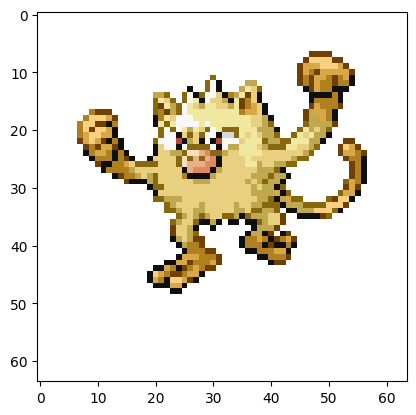

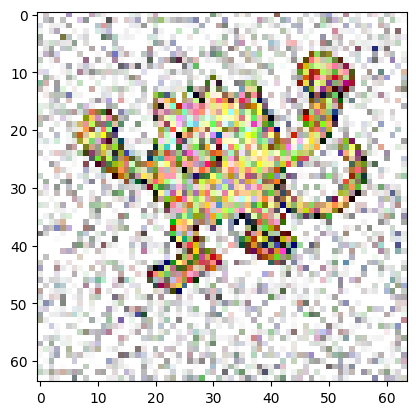

In [18]:
t = 30
x0 = pimages[0][55]

z = torch.randn(x0.shape).to(device)
xt = x0 * torch.sqrt(alpha_[t]) + z * torch.sqrt(1-alpha_[t])

plot_image(x0)
plot_image(xt)

In [3]:
for t in range(T):

    print(f"t = {t}")

    model = PAutoE(4, 4).to(device)

    loss_func = nn.MSELoss()    
    optimizer = optim.SGD(model.parameters(), lr=5e-2)
        
    pbar = tqdm(range(15001))
    def closure():
        optimizer.zero_grad()

        source = randint(0, 2)
        batch = torch.randperm(385)[:4]
        img = pimages[source][batch]

        e = torch.randn(img.size(), device=device)

        # Create the noisy image and send to the model
        imgN = img * torch.sqrt(alpha_[t]) + e * torch.sqrt(1 - alpha_[t])
        pred = model(imgN)

        # Calculate the loss between the result and the noise
        loss = loss_func(pred, e)
        loss.backward()
        
        pbar.set_description(f"%.8f" % loss)
        
        return loss
            
    model.train()
    for j in pbar:
        optimizer.step(closure)

    script = torch.jit.script(model)
    script.save(f"./model_{t}.pt")

t = 0


0.28627098:  68%|██████▊   | 10261/15001 [02:23<01:06, 71.32it/s]


KeyboardInterrupt: 